In [1]:
# Notebook behavior:

# Enable multiple outputs from one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import Markdown, Image

# autoreload extension: automaticall refresh imports when code is changed:
%load_ext autoreload
%autoreload 2

# run_cms_analysis.ipynb
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder.

# Required mcce run output files:
### 1. head3.lst
### 2. file in ms_out/, a.k.a. the 'msout file'
 * Notes:
   - The ms_out folder is retained when the `--ms` flag is used at the command line for Step 4: `step4.py --ms`;
   - Format of the msout file name: pHXeHYms.tx at pH point X and Eh point Y;
   - The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.
---

## Load the needed libraries and modules:

In [2]:
from pathlib import Path
here = Path.cwd()

# Module needed to read the microstate file:
import cms_analysis_wc as msa

---
# Inputs
## Required user input: the path to the msout file:
 * e.g. 4lzt/ms_out/pH7eH0ms.txt
## Optional user input: list of residues of interest
---

# Get the paths to the input files using a folder name and a pH point (as string):

In [6]:
mcce_dir = Path("4lzt")  # local folder
msout_file = "pH7eH0ms.txt"

p, e = msout_file[:-4].lower().split("eh")
ph = p.removeprefix("ph")
eh = e.removesuffix("ms")

h3_path, msout_file = msa.get_mcce_input_files(mcce_dir, ph, eh) 

outname = "crgms_corr"
# Ensure the output directory exists:
output_dir = mcce_dir.joinpath(outname)
if not output_dir.exists():
    output_dir.mkdir()

print(f"h3_path: {str(h3_path)}")
print(f"msout_file: {str(msout_file)}")
print(f"output_dir: {str(output_dir)}")

h3_path: /home/cat/projects/raihan/python/microstate_analysis_code/4lzt/head3.lst
msout_file: /home/cat/projects/raihan/python/microstate_analysis_code/4lzt/ms_out/pH7eH0ms.txt
output_dir: 4lzt/crgms_corr


# Residues of interest

Note: Make sure to add the names of your residues of interest, such as quinone, here:

### Which kind of residues to consider (3-letter codes)

#### Code for interactive input to obtain `user_resoi`:
Example string to give:  
ASP, pl9 GLU, LYS ARG HIS, TYR NTR PAA, HEM
   
  ```
  user_resoi = msa.split_spunct(input("Enter which kind of residues are of interest, e.g. ASP, HIS:\n"), upper=True)
  ```

In [7]:
# Which kind of residues to consider (3-letter codes):

user_resoi = ["ASP", "HEM", "PL9", "GLU", "HIS", "TYR", "NTR", "CTR"]
residue_kinds = msa.sort_resoi_list(user_resoi)
print("Sorted resoi kinds:", residue_kinds)

# Specific residues of interest for correlation.
# Here the list supplied must be conformer ids as they appear in the conformers list, without "-" or "+":
choose_res = ["GLUA0035_", "HISA0015_", "ASPA0123_", "LYSA0013_"]

correl_resids = [res for res in choose_res if res[:3] in residue_kinds]
print("Chosen resid for correlation:", correl_resids)

Sorted resoi kinds: ['ASP', 'GLU', 'HIS', 'TYR', 'NTR', 'CTR', 'HEM', 'PL9']
Chosen resid for correlation: ['GLUA0035_', 'HISA0015_', 'ASPA0123_']


### Populate the conformers list:

In [22]:
conformers = msa.read_conformers(h3_path)
n_conformers = len(conformers)
print(f"Conformers count: {n_conformers:,}")

Conformers count: 314


In [9]:
# check correl_resids are in conformers list
correl_resids = msa.check_res_list(correl_resids, confs_lst=conformers)
print("Valid resid for correlation:", correl_resids)

[WARNING]: check_res_list:
	Removing 'ASPA0123_' from correl_lst: not in conformers.


Valid resid for correlation: ['GLUA0035_', 'HISA0015_']


# Instantiate `msa.MSout` class with the given msout file:

In [20]:
mc = msa.MSout(msout_file)
print(mc)


Number of microstates: 1,500,000
Number of unique microstates: 394,139
Energies: lowest_E: -184.97; average_E: -179.39; highest_E: -166.75
Free residues: 47
Fixed residues: 81



#### [ optional ]
#### Learn which methods come with the instantiated class (mc)
 * What's in the MSout class?

### In MCCE, residues are divided into fixed or free residue groups.
 * Only free residues appear in the microstate sate list.
 * Fixed residues can be ionizable residues so we need to include their contribution to the total charge, which is referred to here as __background charge__. 

#### Free residues information

In [23]:
# Uncomment to display:

#print("mc.free_residues list holds each free residues' conformers.\nSample data:\n", mc.free_residues[:2])

In [83]:
# Save the free_residues in a pandas.DataFrame, it will be one of the inputs to the function msa.ConcaCrgMsPandas:
free_residues_df = msa.free_residues_to_df(mc.free_residues, conformers, colname="Residue")
print(f"Number of free residues: {free_residues_df.shape[0]:,}")

Number of free residues: 47


In [84]:
# Uncomment to display:

#free_residues_df.head(3)
#free_residues_df.tail(3)

In [85]:
# Get their net charges into a df for combining with fixed_res

free_res_crg_df = msa.free_res2sumcrg_df(mc.microstates.values(), mc.free_residues, conformers)

In [86]:
# Uncomment to display:

#free_res_crg_df.head()

#### Fixed residues charge.
(Make sure to account for fixed residues charge for MD simulation protonation input.)

__For all fixed residues:__  
```
fixed_residues_info(
    fixed_iconfs: list, conformers: list, res_of_interest: list = IONIZABLES
) -> Tuple[float, pd.DataFrame, dict]:
```

In [87]:
background_crg, all_fixed_res_crg_df, all_fixed_res_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs, conformers)

print("Background charge:", background_crg)
print("Number of fixed residues:", len(all_fixed_res_crg_dict))

Background charge: 8.0
Number of fixed residues: 25


In [88]:
# Uncomment to display:

#all_fixed_res_crg_df.head()

### Combine free & fixed res with crg and save to csv:

In [89]:
all_res_crg_df = msa.combine_all_free_fixed_residues(free_res_crg_df, all_fixed_res_crg_df)
print(f"{all_res_crg_df.shape = }")

# Save to csv:
# file_name :: all_res_crg_csv
all_res_crg_df.to_csv(output_dir.joinpath("all_res_crg_ph7.csv"), index_label="Residue")

all_res_crg_df.shape = (2, 72)


In [90]:
# Uncomment to display:

#all_res_crg_df

__For fixed residues among residues of interest:__  
#### Save the fixed residues in your residues of interest to a separate list, DataFrame & csv:

In [91]:
background_crg, fixed_resoi_crg_df, fixed_resoi_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs,
                                                                                   conformers,
                                                                                   residue_kinds)
n_fixed_resoi = fixed_resoi_crg_df.shape[0]
if n_fixed_resoi:
    print("Fixed res in residues of interest:", n_fixed_resoi)
    # save to csv:
    fixed_resoi_crg_df.to_csv(output_dir.joinpath("fixed_crg_resoi_ph7.csv"), index=False)
else:
    fixed_resoi_crg_df = None
    print("No fixed residues of interest.")

Fixed res in residues of interest: 9


In [92]:
# Uncomment to display:

#if n_fixed_resoi:
#    fixed_resoi_crg_df

#### The following saves sorted microstates attributes (energy, count and microstate state) into a list;
  * `ms_orig_lst` holds each microstate's attributes sorted by energy.
  * The first attribute is the microstate energy, the second is the multiplicity of that state (mso.microstates holds unique ms info), the last one is the list of conformers in that state.
  * The conformer numbers align with head3.lst. Head3.lst starts at 1; ms lists start at 0.

In [93]:
# mc.sort_microstates() returns a list of sorted ms objects:

ms_orig_lst = [[ms.E, ms.count, ms.state] for ms in mc.sort_microstates()]

In [94]:
# Sample data (uncomment to display):

#len(ms_orig_lst)
#print(ms_orig_lst[:2])

### Plot the enthalpy distribution using `msa.ms_energy_histogram`:
   ```
    msa.ms_energy_histogram(ms_by_enrg: list,
                            out_dir: pathlib.Path,
                            save_name: str = 'enthalpy_dist.pdf',
                            show: bool = False)
   ```

[INFO]: ms_energy_histogram:
	Histogram figure saved as 4lzt/crgms_corr/enthalpy_dist.png


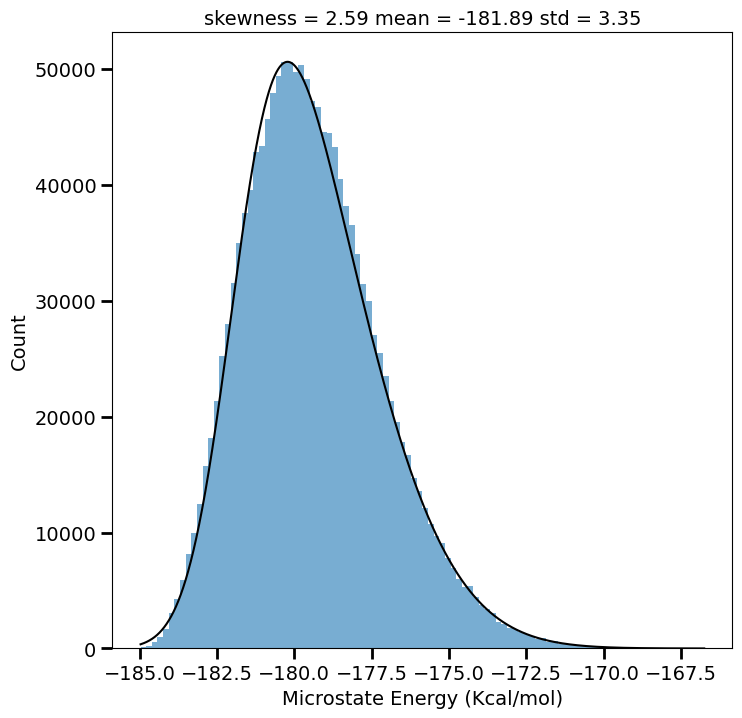

In [95]:
msa.ms_energy_histogram(ms_orig_lst, output_dir, show=True)

---
## Conformer microstates to charge microstates conversion

### This will map the microstate conformer id to its corresponding charge, and convert the conformer microstates from `mc` to charge microstates:

In [96]:
# Map conf index to conf charge:
id_vs_charge = msa.iconf2crg(conformers)

# This list structure is similar to that in ms_orig_lst;
# For each ms, it holds a list = [E, count, [crgms state]], but now the state list gives the charge
# of the free residues coformers:
crg_orig_lst = msa.ms2crgms(ms_orig_lst, id_vs_charge)

In [97]:
# Sample data (uncomment to display):

#print(crg_orig_lst[:2])

---
# Process the charge microstates into various outputs

## Unfiltered charge microstates
### Note: Outputs of msa.find_uniq_crgms_count_order:
```
  0: all_crg_ms_unique,
  1: all_count,
  2: unique_crg_state_order,
  3: energy_diff_all (used in plot)
```

In [98]:
print("Using unfilteresd charge microstate energies.")

crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst)

all_crg_count_res = msa.concat_crgms_dfs(crgms_files[0],
                                         crgms_files[1],
                                         crgms_files[2], 
                                         free_residues_df,
                                         background_crg,
                                         res_of_interest=residue_kinds
                                         )

[INFO]: find_uniq_crgms_count_order:
	No energy bounds given: All microstates are selected.
[INFO]: find_uniq_crgms_count_order:
	Number of charge ms: 394,139


Using unfilteresd charge microstate energies.


[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 15


In [99]:
# Sample data (uncomment to display):

#all_crg_count_res.head()

### This will plot the tautomer charge distribution of unqiue charge microstates based on the occupancy. 
Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

### In `msa.unique_crgms_histogram`, the color variation (hue) indicates the size of the energy range for non-unique crgms. The size of the circle reflects the count.

[INFO]: unique_crgms_histogram:
	Figure saved: 4lzt/crgms_corr/crgms_logcount_vs_all_E_ph7.png


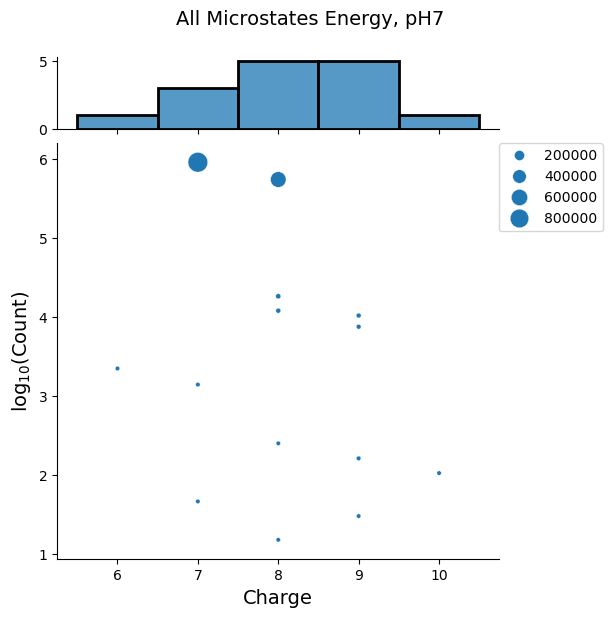

In [100]:
title = "All Microstates Energy, pH" + ph
msa.unique_crgms_histogram(crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_all_E_ph"+ph+".png",
                           show=True)

#### This is to get the unique charge microstates >= lowest energy + 1.36 kcal/mol. 
Make sure your supply list is sorted based on energy in ascending order. 
The order in the dataframe is within the selected energy range.

In [101]:
begin_E = crg_orig_lst[0][0]
end_E = crg_orig_lst[0][0] + 1.36
print(f"Using charge microstate energies within 1 pH unit (+ 1.36 kcal/mol) of the lowest E: ({begin_E}, {end_E})")

lowest_crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst,
                                                   begin_energy = begin_E,
                                                   end_energy = end_E
                                                   )
lowest_crg_count_res = msa.concat_crgms_dfs(lowest_crgms_files[0],
                                            lowest_crgms_files[1],
                                            lowest_crgms_files[2], 
                                            free_residues_df,
                                            background_crg,
                                            res_of_interest=residue_kinds)

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 2,198
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 2


Using charge microstate energies within 1 pH unit (+ 1.36 kcal/mol) of the lowest E: (-184.972214, -183.612214)


In [102]:
# Sample data (uncomment to display):

#lowest_crg_count_res.head(3) 

[INFO]: unique_crgms_histogram:
	Figure saved: 4lzt/crgms_corr/crgms_logcount_vs_lowest_E_ph7.png


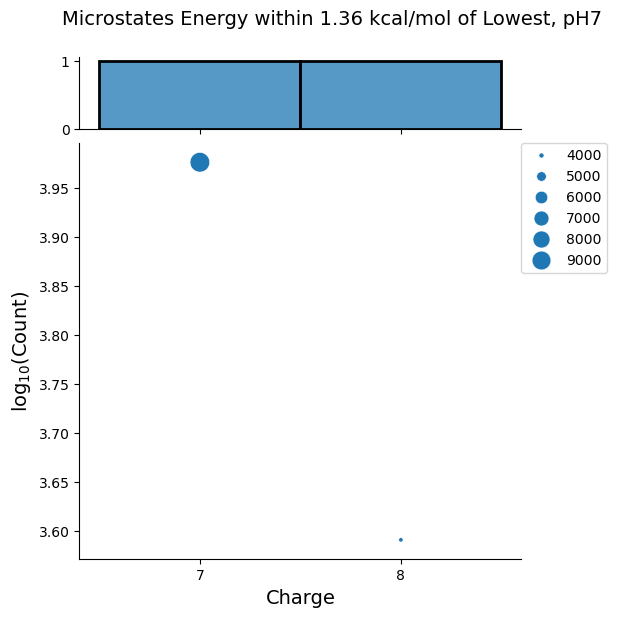

In [103]:
title = "Microstates Energy within 1.36 kcal/mol of Lowest, pH"+ph
msa.unique_crgms_histogram(lowest_crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_lowest_E_ph"+ph+".png",
                           show=True)

#### This is to get the unique charge microstates within +/- 0.5 pH unit (+/- 0.68 kcal/mol) of average microstate energy

In [104]:
begin_mc_aver = mc.average_E - 0.68
end_mc_aver = mc.average_E + 0.68
print("Using charge microstates energies within +/- 0.5 pH unit (+/- 0.68 kcal/mol)",
      f"of the average conformer microstate energy: ({begin_mc_aver}, {end_mc_aver})")

aver_crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst,
                                                   begin_energy = begin_mc_aver,
                                                   end_energy = end_mc_aver)
av_crg_count_res = msa.concat_crgms_dfs(aver_crgms_files[0],
                                        aver_crgms_files[1],
                                        aver_crgms_files[2], 
                                        free_residues_df,
                                        background_crg,
                                        res_of_interest=residue_kinds
                                       )

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 93,790


Using charge microstates energies within +/- 0.5 pH unit (+/- 0.68 kcal/mol) of the average conformer microstate energy: (-180.07293514108827, -178.71293514108825)


[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 9


In [105]:
# Sample data (uncomment to display):

#av_crg_count_res.head(3) 

[INFO]: unique_crgms_histogram:
	Figure saved: 4lzt/crgms_corr/crgms_logcount_vs_aver_E_ph7.png


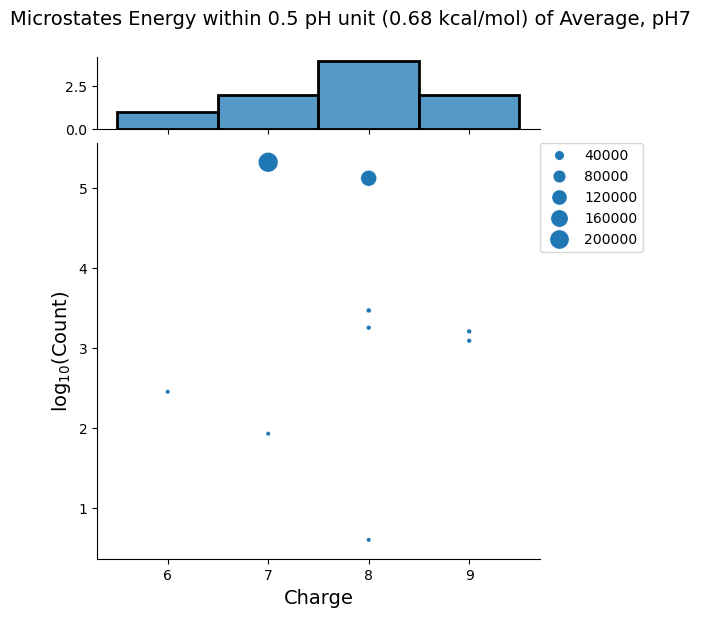

In [107]:
title = "Microstates Energy within 0.5 pH unit (0.68 kcal/mol) of Average, pH"+ph
msa.unique_crgms_histogram(aver_crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_aver_E_ph"+ph+".png",
                           show=True)

#### This is to get the unique charge microstates >= 1 KT unit (1.36 kcal/mol) of highest microstate energy

In [108]:
begin_mc_highest = mc.highest_E - 1.36
end_mc_highest = mc.highest_E
print("Using charge microstates energies within 1 pH unit (- 1.36 kcal/mol)",
      f"of the highest conformer microstate energy: ({begin_mc_highest}, {end_mc_highest})")


highest_crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst,
                                                      begin_energy = begin_mc_highest,
                                                      end_energy = end_mc_highest)

high_crg_count_res = msa.concat_crgms_dfs(highest_crgms_files[0],
                                          highest_crgms_files[1],
                                          highest_crgms_files[2], 
                                          free_residues_df,
                                          background_crg,
                                          res_of_interest=residue_kinds)

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 9
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 3


Using charge microstates energies within 1 pH unit (- 1.36 kcal/mol) of the highest conformer microstate energy: (-168.10801600000002, -166.748016)


In [109]:
# Sample data (uncomment to display):

#high_crg_count_res.head(3) 

[INFO]: unique_crgms_histogram:
	Figure saved: 4lzt/crgms_corr/crgms_logcount_vs_highest_E_ph7.png


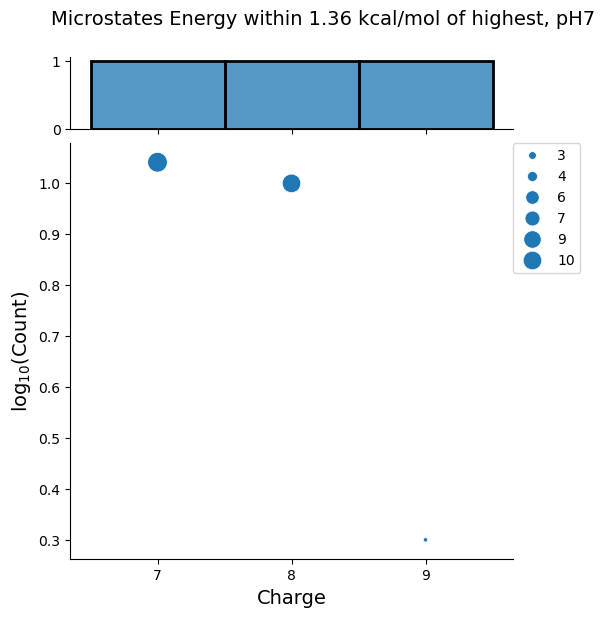

In [110]:
title = "Microstates Energy within 1.36 kcal/mol of highest, pH"+ph
msa.unique_crgms_histogram(highest_crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_highest_E_ph"+ph+".png",
                           show=True)

### [ Optional ] Save all these 3 DataFrames and non titrable residues charge information to excel:
 * low_crg_count_res
 * av_crg_count_res
 * high_crg_count_res
 * fixed_resoi_crg_df

Copy the following code to a cell:
```
xl_filename = "charge_ms_pH"+ ph + ".xlsx"
xl_filepath = output_dir.joinpath(xl_filename)
dfs = [(low_crg_count_res, "low_crg_count_res"),
       (av_crg_count_res, "av_crg_count_res"),        
       (high_crg_count_res, "high_crg_count_res"),
       (fixed_resoi_crg_df, "fixed_resoi_crg")
       ]

# Note: this will fail if the write_engine program is not installed; default: "xlsxwriter":
msa.dfs_to_excel(dfs, xl_filepath)
```

### Save all_crg_count_res to a CSV file after adding fixed resoi data:

In [111]:
all_crg_df = msa.add_fixed_res_crg(all_crg_count_res, fixed_resoi_crg_df)

crg_count_csv = output_dir.joinpath(f"all_crg_count_res_ph{ph}.csv")
try:
    all_crg_df.to_csv(crg_count_csv, header=True)
    print(f"DataFrame all_crg_count_res saved to {crg_count_csv!s}.")
except Exception as e:
    print(f"Error occurred while saving all_crg_count_res to csv file: {str(e)}")

DataFrame all_crg_count_res saved to 4lzt/crgms_corr/all_crg_count_res_ph7.csv.


---
# Processing of main crgms data to get the correlation matrix for residues.
### Note: `msa.choose_res_data` will remove fixed residues

In [112]:
df_choose_res_data = msa.choose_res_data(all_crg_df, correl_resids, fixed_resoi_crg_df)
df_choose_res_data["Occupancy"] = round(df_choose_res_data["Count"]/sum(df_choose_res_data["Count"]), 2)

file_name = "crg_count_res_of_interest.csv"
df_choose_res_data.to_csv(output_dir.joinpath(file_name), header=True)

# Relabel residues with shorter names:
df_chosen_res_renamed = msa.rename_order_residues(df_choose_res_data)

In [113]:
# Uncomment to display:

#df_choose_res_data

In [114]:
# Uncomment to display:

#df_chosen_res_renamed

---
# Weighted correlation
### Define a cutoff if one different from 0.02 (default) is needed.

In [115]:
cutoff = 0

df_correlation = msa.WeightedCorr(df=df_chosen_res_renamed,
                                  wcol="Count",
                                  cutoff=cutoff)(method="pearson")

In [116]:
# Uncomment to display:

df_correlation

,AE35,AH15
AE35,1.000000,-0.003784
AH15,-0.003784,1.000000


## Create a clustered heatmap to display the residue correlation:

In [117]:
clustered_corr = msa.cluster_corr_matrix(df_correlation)

msa.corr_heatmap(clustered_corr,
                 out_dir=output_dir,
                 save_name="corr_ph7.pdf",
                 show=True)

[WARNING]: corr_heatmap:
	All off-diagonal correlation values are 0.00: not plotting.
